In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.svm import SVC, LinearSVC , LinearSVR
from keras.layers import Dense , LSTM
from keras.models import Sequential
import tensorflow as tf
pd.set_option('max_columns', 30)
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

Using TensorFlow backend.


# Importing Dataset FD003

In [3]:
def load_train_data(train_FD003):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\train_FD003'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [4]:
def load_test_data(FD003):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\test_FD003'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\RUL_FD003' + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data

In [5]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [6]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

In [8]:
train_fd1 = load_train_data('FD003')
test_fd1 = load_test_data('FD003')

# Data Visualisation

In [9]:
train_fd1.describe()

,unit,cycle,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,total_cycles,RUL
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,24720.00,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,518.67,642.457858,1588.079175,1404.471212,1.462000e+01,21.595841,555.143808,2388.071555,9064.110809,1.301232,47.415707,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024,277.154126,138.077063
std,29.348985,98.846675,0.002194,0.000294,0.0,0.00,0.523031,6.810418,9.773178,3.552786e-15,0.018116,3.437343,0.158285,19.980294,0.003485,0.300074,3.255314,0.158121,16.504118,0.060512,1.734759e-17,1.761459,0.0,0.0,0.248865,0.149234,100.537886,98.846675
min,1.000000,1.000000,-0.008600,-0.000600,100.0,518.67,640.840000,1564.300000,1377.060000,1.462000e+01,21.450000,549.610000,2386.900000,9017.980000,1.290000,46.690000,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600,145.000000,0.000000
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,518.67,642.080000,1583.280000,1397.187500,1.462000e+01,21.580000,553.110000,2388.000000,9051.920000,1.300000,47.190000,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200,197.000000,61.000000
50%,47.000000,124.000000,0.000000,-0.000000,100.0,518.67,642.400000,1587.520000,1402.910000,1.462000e+01,21.600000,554.050000,2388.070000,9060.010000,1.300000,47.360000,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600,253.000000,123.000000
75%,74.000000,191.000000,0.001500,0.000300,100.0,518.67,642.790000,1592.412500,1410.600000,1.462000e+01,21.610000,556.040000,2388.140000,9070.092500,1.300000,47.600000,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300,324.000000,190.000000
max,100.000000,525.000000,0.008600,0.000700,100.0,518.67,645.110000,1615.390000,1441.160000,1.462000e+01,21.610000,570.490000,2388.600000,9234.350000,1.320000,48.440000,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500,525.000000,524.000000


In [10]:
train_fd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24720 entries, 0 to 24719
Data columns (total 28 columns):
unit            24720 non-null int64
cycle           24720 non-null int64
2               24720 non-null float64
3               24720 non-null float64
4               24720 non-null float64
5               24720 non-null float64
6               24720 non-null float64
7               24720 non-null float64
8               24720 non-null float64
9               24720 non-null float64
10              24720 non-null float64
11              24720 non-null float64
12              24720 non-null float64
13              24720 non-null float64
14              24720 non-null float64
15              24720 non-null float64
16              24720 non-null float64
17              24720 non-null float64
18              24720 non-null float64
19              24720 non-null float64
20              24720 non-null float64
21              24720 non-null int64
22              24720 non-null int64
23

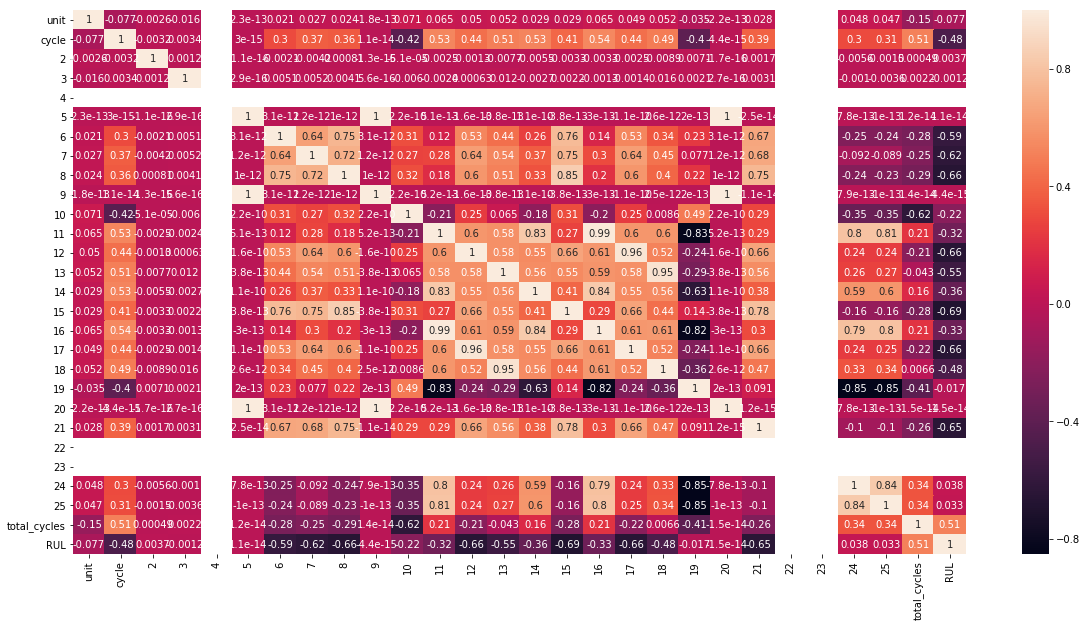

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(train_fd1.corr() , annot = True)

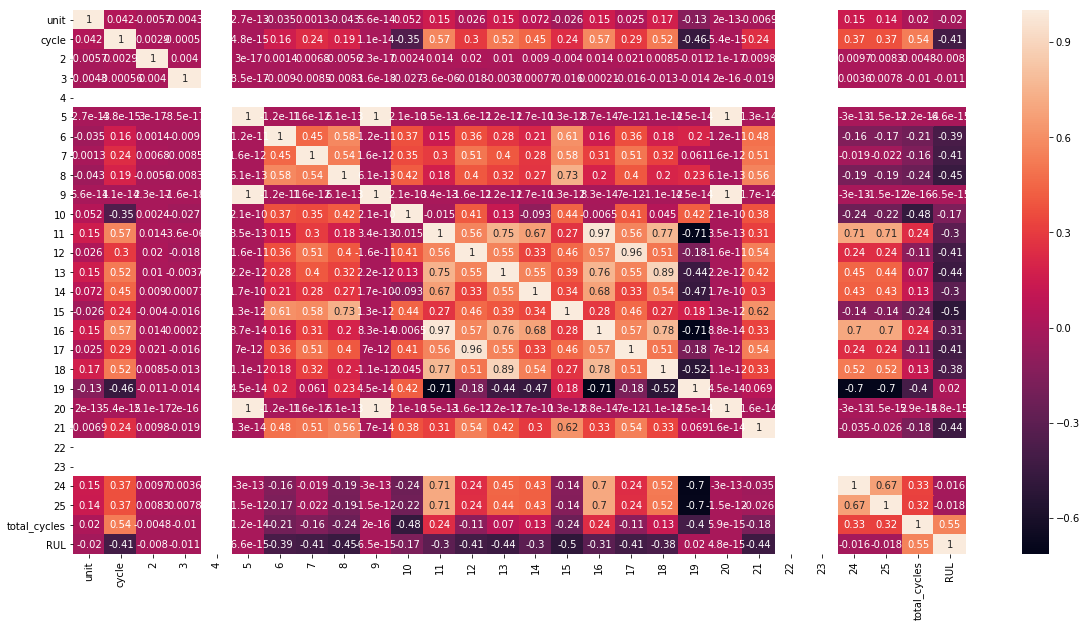

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(test_fd1.corr() , annot = True)

In [13]:
features = list(range(2, 26))

train_fd1[features] = train_fd1[features].apply(normalize, axis = 0)
test_fd1[features] = test_fd1[features].apply(normalize, axis = 0)

test_rows = test_fd1.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_fd1, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [14]:
y = train_fd1['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_fd1[features].dropna(how = 'all', axis = 1)

X = X.as_matrix()
X_pred = X_pred.as_matrix()

y_real = test_rows['RUL'].values

In [15]:
print(y.shape)
print(X.shape)
print(X_pred.shape)
print(y_real.shape)

(24720,)
(24720, 20)
(100, 20)
(100,)


# Neural Network Regressor

In [16]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [20])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dell\\AppData\\Local\\Temp\\tmpr334ifxe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B4B1E50EF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for upd

In [17]:
print(y_pred)

<generator object Estimator.predict at 0x000001B4B1E31258>


In [18]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmpr334ifxe\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [19]:
print(y_pred)

[  8.852841   45.608955    8.297878  117.15813   189.45413    63.935654
  60.382156   35.827763   20.728357   50.988785   16.804117   79.91714
  35.594635   17.87191   130.73265   160.03593    80.48814    87.084175
  66.63817    32.47261     8.297878  135.64102    24.945192    8.297878
  26.84297    49.17174    69.82291    41.52935   110.63765    23.160679
  41.47629     7.0193167  34.302303   53.360943   98.18453   134.90083
 127.091194    6.9831433   8.297878   10.413987  146.3563     63.075985
 143.10896    47.232746  133.51682     8.297878  137.07591    11.208219
 198.4149      9.546784   68.340256   66.495056   71.56719   116.499405
  17.800371   25.89666    32.446064   16.715626    8.297878   76.051
 225.29163    12.666425  103.20747     8.297878  132.69395    42.176956
  48.22865   118.700356  131.75377    45.19695     8.297878   43.749866
  87.14136   117.26403    18.136211   39.86477    19.800295    8.297878
  16.281887  354.20428     9.136451   12.933336   75.222946   65.4772

In [20]:
print(len(X))
print(len(y))
print(len(y_pred))
print(len(y_real))

24720
24720
100
100


In [21]:
print(y_real)

[ 44  51  27 120 101  99  71  55  55  66  77 115 115  31 108  56 136 132
  85  56  18 119  78   9  58  11  88 144 124  89  79  55  71  65  87 137
 145  22   8  41 131 115 128  69 111   7 137  55 135  11  78 120  87  87
  55  93  88  40  49 128 129  58 117  28 115  87  92 103 100  63  35  45
  99 117  45  27  86  20  18 133  15   6 145 104  56  25  68 144  41  51
  81  14  67  10 127 113 123  17   8  28]


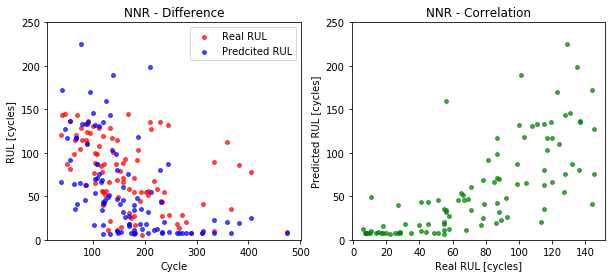

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('NNR - Difference')

axes[1].scatter(y_real, y_pred, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('NNR - Correlation')

axes[0].legend()

plt.show()

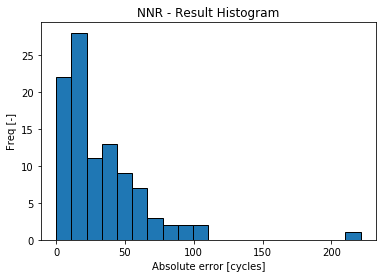

In [23]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('NNR - Result Histogram')
plt.show()

In [24]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))

Average score per UUT: 40437723.78718275
Mean squared Error: 4.470293422252298
Median difference: 22.14203453063965


# Support Vector Machine Regressor

In [25]:
model = svm.SVR()
model.fit(X, y)
y_pred_svm = model.predict(X_pred)

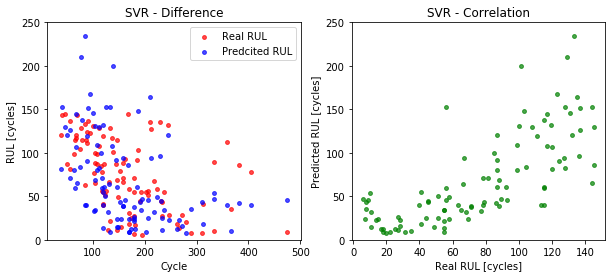

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred_svm, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('SVR - Difference')

axes[1].scatter(y_real, y_pred_svm, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('SVR - Correlation')

axes[0].legend()

plt.show()

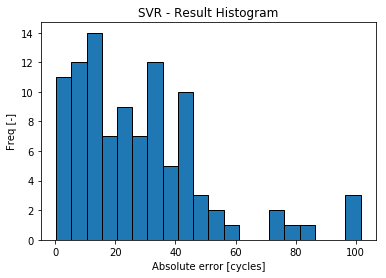

In [27]:
plt.hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('SVR - Result Histogram')
plt.show()

In [28]:
print('Average score per UUT:', compute_score(y_real, y_pred_svm) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_svm))
print('Median difference:', np.median(np.abs(y_real - y_pred_svm)))

Average score per UUT: 677.160860977872
Mean squared Error: 3.538247936669866
Median difference: 22.96334910898597


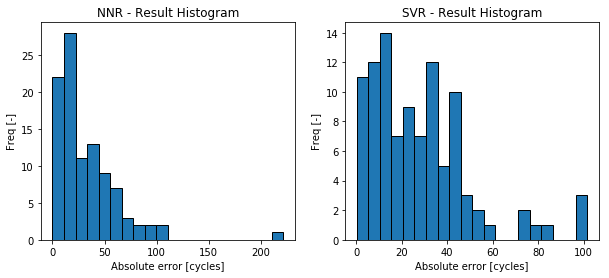

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0].set_xlabel('Absolute error [cycles]')
axes[0].set_ylabel('Freq [-]')
axes[0].set_title('NNR - Result Histogram')

axes[1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[1].set_xlabel('Absolute error [cycles]')
axes[1].set_ylabel('Freq [-]')
axes[1].set_title('SVR - Result Histogram')
plt.show()

# Decision Tree Regressor

In [30]:
regr_1 = DecisionTreeRegressor(max_depth= 4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 4),
                          n_estimators=300, random_state = None)

regr_1.fit(X, y)
regr_2.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=None)

In [31]:
y_1 = regr_1.predict(X_pred)
y_2 = regr_2.predict(X_pred)

In [32]:
print(len(X))
print(len(y))
print(len(y_1))
print(len(y_2))
len(X) == len(y)

24720
24720
100
100


True

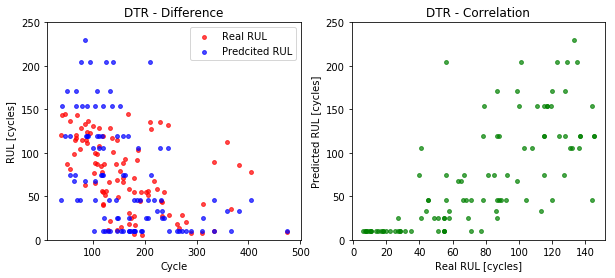

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_1, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTR - Difference')

axes[1].scatter(y_real, y_1, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTR - Correlation')

axes[0].legend()

plt.show()

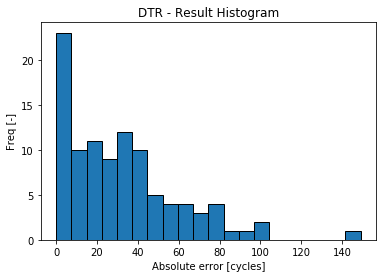

In [34]:
plt.hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTR - Result Histogram')
plt.show()

In [35]:
print('Average score per UUT:', compute_score(y_real, y_1) / 100)
print('Mean squared Error:', MSE(y_real, y_1))
print('Median difference:', np.median(np.abs(y_real - y_1)))

Average score per UUT: 30086.630423929608
Mean squared Error: 4.237683168225024
Median difference: 25.791523972602747


# Decision Tree Regressor using Adaboost

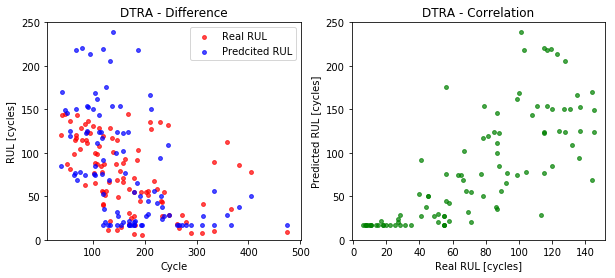

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_2, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTRA - Difference')

axes[1].scatter(y_real, y_2, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTRA - Correlation')

axes[0].legend()

plt.show()

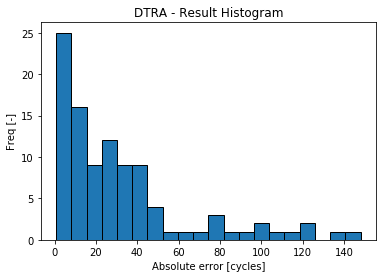

In [37]:
plt.hist(np.abs(y_real - y_2), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTRA - Result Histogram')
plt.show()

In [38]:
print('Average score per UUT:', compute_score(y_real, y_2) / 100)
print('Mean squared Error:', MSE(y_real, y_2))
print('Median difference:', np.median(np.abs(y_real - y_2)))

Average score per UUT: 42523.934231288666
Mean squared Error: 4.579581761338753
Median difference: 22.389855261018056


# KNN Regressor

In [39]:
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

In [40]:
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [41]:
y_3 = neigh.predict(X_pred)

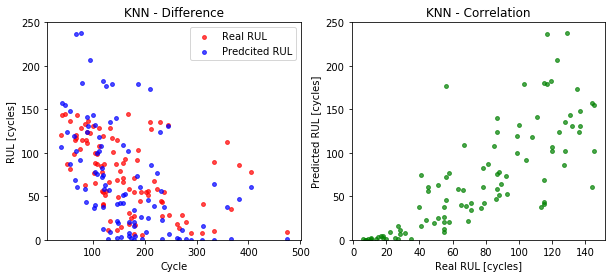

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_3, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('KNN - Difference')

axes[1].scatter(y_real, y_3, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('KNN - Correlation')

axes[0].legend()

plt.show()

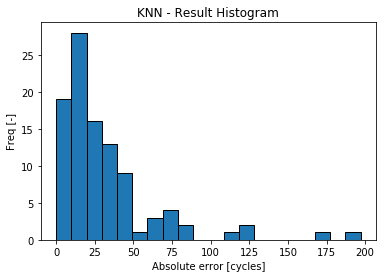

In [43]:
plt.hist(np.abs(y_real - y_3), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('KNN - Result Histogram')
plt.show()

In [44]:
print('Average score per UUT:', compute_score(y_real, y_3) / 100)
print('Mean squared Error:', MSE(y_real, y_3))
print('Median difference:', np.median(np.abs(y_real - y_3)))

Average score per UUT: 3876636.5885898555
Mean squared Error: 4.572261977603288
Median difference: 22.0


# Random Forest Regressor

In [45]:
regr1 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
regr1.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [46]:
y_4 = regr1.predict(X_pred)

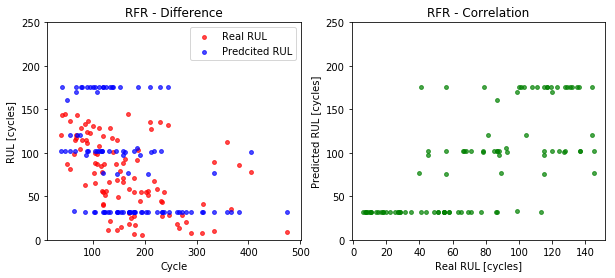

In [47]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_4, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('RFR - Difference')

axes[1].scatter(y_real, y_4, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('RFR - Correlation')

axes[0].legend()

plt.show()

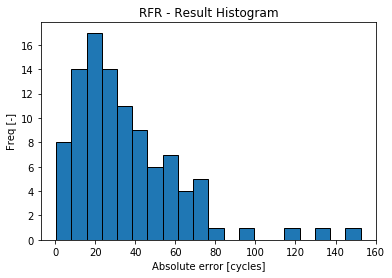

In [48]:
plt.hist(np.abs(y_real - y_4), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('RFR - Result Histogram')
plt.show()

In [49]:
print('Average score per UUT:', compute_score(y_real, y_4) / 100)
print('Mean squared Error:', MSE(y_real, y_4))
print('Median difference:', np.median(np.abs(y_real - y_4)))

Average score per UUT: 50672.05031964761
Mean squared Error: 4.46846936991211
Median difference: 26.082648223552347


# Conclusion

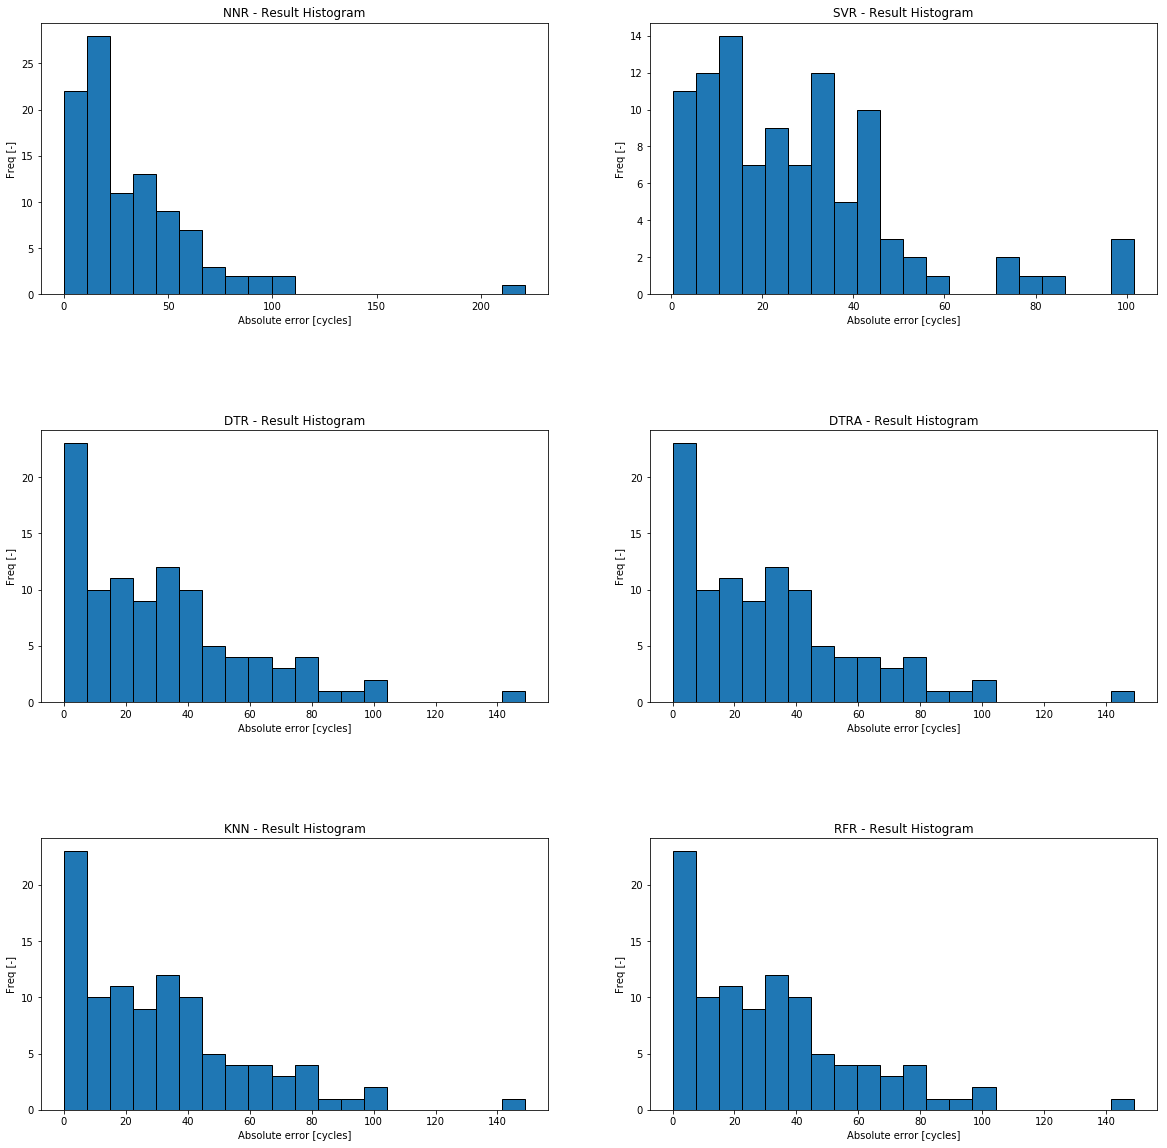

In [50]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0,0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0,0].set_xlabel('Absolute error [cycles]')
axes[0,0].set_ylabel('Freq [-]')
axes[0,0].set_title('NNR - Result Histogram')

axes[0,1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[0,1].set_xlabel('Absolute error [cycles]')
axes[0,1].set_ylabel('Freq [-]')
axes[0,1].set_title('SVR - Result Histogram')

axes[1,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,0].set_xlabel('Absolute error [cycles]')
axes[1,0].set_ylabel('Freq [-]')
axes[1,0].set_title('DTR - Result Histogram')

axes[1,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,1].set_xlabel('Absolute error [cycles]')
axes[1,1].set_ylabel('Freq [-]')
axes[1,1].set_title('DTRA - Result Histogram')

axes[2,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,0].set_xlabel('Absolute error [cycles]')
axes[2,0].set_ylabel('Freq [-]')
axes[2,0].set_title('KNN - Result Histogram')

axes[2,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,1].set_xlabel('Absolute error [cycles]')
axes[2,1].set_ylabel('Freq [-]')
axes[2,1].set_title('RFR - Result Histogram')

plt.show()